In [64]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score 
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from scipy.optimize import curve_fit

In [65]:
f = open("seattle-weather.csv", "r")
orig_df = pd.read_csv(f)

In [66]:
# Check for null values
orig_df.isnull().any()
# Found zero null values

date             False
precipitation    False
temp_max         False
temp_min         False
wind             False
weather          False
dtype: bool

In [67]:
# Get the important info from orig_df, and add the month info

df = orig_df[["date", "precipitation", "wind", "temp_max", "temp_min"]].copy()
for i in range(1, 13):
    df["month"+str(i)] = [ 
        int(datetime.strptime(date_str, '%Y-%m-%d').month == i)
        for _, date_str in df["date"].items()
]

In [68]:
# Normalize wind and precipitation

df["precipitation"] = df["precipitation"] / df["precipitation"].max()
df["wind"] = df["wind"] / df["wind"].max()

In [69]:
# Add yesterday's max and min temperatures

yest_temp_max = df["temp_max"].tolist()
yest_temp_min = df["temp_min"].tolist()
yest_temp_max.pop()
yest_temp_min.pop()
df = df.drop(0)
df = df.reset_index(drop=True)
df["yest_temp_max"] = yest_temp_max
df["yest_temp_min"] = yest_temp_min

In [70]:
# Adding info about weather conditions

zeros_list = [0 for _ in range(len(df))]
df["is_sun"] = zeros_list.copy()
df["is_drizzle"] = zeros_list.copy()
df["is_rain"] = zeros_list.copy()
df["is_snow"] = zeros_list.copy()

for key, val in orig_df["weather"].items():
    if val == "sun":
        df.at[key, "is_sun"] = 1
    elif val == "drizzle":
        df.at[key, "is_drizzle"] = 1
    elif val == "rain":
        df.at[key, "is_rain"] = 1
    elif val == "snow":
        df.at[key, "is_snow"] = 1

In [72]:
# Drop rows containing NaN

df = df.dropna()

In [46]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=["temp_max"]), df["temp_max"], test_size=0.3)

In [74]:
X_test = df.drop(columns=["temp_max"])[:731]
y_test = df["temp_max"][:731]
X_train = df.drop(columns=["temp_max"])[731:]
y_train = df["temp_max"][731:]

In [75]:
model = LinearRegression()

In [76]:
model.fit(X_train.drop(columns=["date"]).values, y_train.values)

LinearRegression()

In [77]:
pred = model.predict(X_test.drop(columns=["date"]).values)

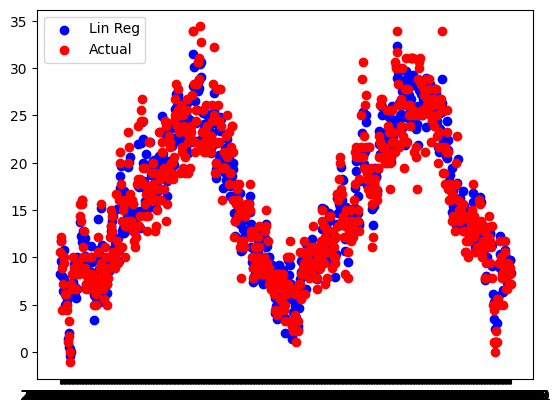

In [78]:
plt.scatter(X_test["date"], pred, label="Lin Reg", color="b")
plt.scatter(X_test["date"], y_test.values, label="Actual", color="r")
plt.legend()

In [79]:
r2_score(pred, y_test.values)

0.8751801796832683